In [24]:
import numpy as np
import random
from numpy.random import randn
from matplotlib import pyplot as plt

In [25]:
positives = 100
negatives = 50
signal_length = 15
max_pulse_length = 14

input_signals = np.zeros((positives + negatives,signal_length,1))
targets = np.zeros(positives + negatives,dtype=int)
for i in range(positives):
    targets[i] = 1
    pulse_length = random.randint(1,max_pulse_length+1)
    pulse_start = random.randint(0,signal_length - pulse_length)
    for j in range(pulse_length):
        input_signals[i][pulse_start+j][0] = 1


In [26]:
class LeakyRNN:
    
    # Modified from https://github.com/KTAswathi/IPB_2023/blob/main/IPB_lab3_BPTT.ipynb
    def __init__(self, input_size, output_size, ntc, hidden_size=64):
        # Weights
        self.Whh = randn(hidden_size, hidden_size) / 1000
        self.Wxh = randn(hidden_size, input_size) / 1000
        self.Why = randn(output_size, hidden_size) / 1000
    
        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

        # Neuronal time constant
        self.ntc = ntc
    
    def forward(self, inputs, neuromod):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        '''
        inputs = np.reshape(inputs,(inputs.shape[0],inputs.shape[1],1))
        h = np.zeros((self.Whh.shape[0], 1))
        self.last_inputs = inputs
        self.last_hs = { 0: h }
        # Perform each step of the RNN
        for i, x in enumerate(inputs):
            # Added leak and neuromodulator parameterised activation function
            h = h + self.ntc * (-h + neuro_activation(self.Wxh @ x + self.Whh @ h + self.bh,neuromod,relu))
            self.last_hs[i + 1] = h
        
        # Compute the output
        y = self.Why @ h + self.by
        return y, h

    def backprop(self, d_y, learn_rate=2e-2):
        '''
        Perform a backward pass of the RNN.
        - d_y (dL/dy) has shape (output_size, 1).
        - learn_rate is a float.
        '''
        n = len(self.last_inputs)
    
        # Calculate dL/dWhy and dL/dby.
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y
    
        # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)
    
        # Calculate dL/dh for the last h.
        d_h = self.Why.T @ d_y
    
        # Backpropagate through time.
        for t in reversed(range(n)):
            # An intermediate value: dL/dh * (1 - h^2)
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)
            
            # dL/db = dL/dh * (1 - h^2)
            d_bh += temp
            
            # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
            d_Whh += temp @ self.last_hs[t].T
            
            # dL/dWxh = dL/dh * (1 - h^2) * x
            d_Wxh += temp @ self.last_inputs[t].T
            
            # Next dL/dh = dL/dh * (1 - h^2) * Whh
            d_h = self.Whh @ temp
    
        # Clip to prevent exploding gradients.
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d)
    
        # Update weights and biases using gradient descent.
        self.Whh -= learn_rate * d_Whh
        self.Wxh -= learn_rate * d_Wxh
        self.Why -= learn_rate * d_Why
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by

#Applies activation function scaled by neuromodulator
alpha = 1.0
def neuro_activation(x, n, func):
    return func(x * (alpha * n + np.ones(n.shape)))

def relu(x):
    return np.maximum(0,x)

In [27]:
def processData(input_data, targets, neuromods, rnn, lr=2e-2, backprop=True):
    '''
    Returns the RNN's loss and accuracy for the given data.
    - data is a dictionary mapping text to True or False.
    - backprop determines if the backward phase should be run.
    '''
    
    loss = 0
    num_correct = 0
    
    for i in range(len(input_data)):
        inputs = input_data[i]
        target = targets[i]
    
        # Forward
        out, _ = rnn.forward(inputs,neuromods)
        probs = softmax(out)
        
        # Calculate loss / accuracy
        loss -= np.log(probs[target] + 1e-15)
        num_correct += int(np.argmax(probs) == target)
        
        if backprop:
            # Build dL/dy
            d_L_d_y = probs
            d_L_d_y[target] -= 1
            
            # Backward
            rnn.backprop(d_L_d_y,learn_rate=lr)
    
    return loss / len(input_data), num_correct / len(input_data)

In [67]:
h_size = 20
epochs = 1000

def softmax(xs):
  # Applies the Softmax Function to the input array.
    s_xs = xs - np.max(xs)
    return np.exp(s_xs) / sum(np.exp(s_xs))

loss_curves = []
acc_curves = []
test_loss_curves = []
test_acc_curves = []

perm = np.random.permutation(len(input_signals))
input_signals = input_signals[perm]
targets = targets[perm]

train_size = int(0.8 * len(input_signals))

train_input = input_signals[:train_size]
train_targets = targets[:train_size]
test_input = input_signals[train_size:]
test_targets = targets[train_size:]

rnns = []
nmodsets = []

inhibitory_mask = np.ones((h_size,1))
inhibitory_mask[:int(0.2 * h_size)][0] = -2
inhibitory_mask = inhibitory_mask[np.random.permutation(h_size)]

perm = np.random.permutation(h_size)
for h in range(0,h_size,9):
    rnn = LeakyRNN(1,2,0.5,hidden_size=h_size)
    nmods = np.zeros((h_size,1))
    for i in range(h):
        nmods[i][0] = 1
    nmods = nmods[perm]
    nmods = nmods * inhibitory_mask
    nmodsets.append(nmods)
    loss = []
    acc = []
    test_losses = []
    test_accs = []
    for epoch in range(epochs):
      train_loss, train_acc = processData(train_input,train_targets,nmods,rnn,lr=0.00075)
      test_loss, test_acc = processData(test_input, test_targets,nmods,rnn,backprop=False)

      loss.append(train_loss)
      acc.append(train_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)
      # if epoch % 10 == 9:
      #     print('--- Epoch %d' % (epoch + 1))
      #     print('Train:\tLoss %.3f | Accuracy: %.3f' % (train_loss, train_acc))
      if epoch == epochs-1:
          print(train_acc)
    acc_curves.append(acc)
    loss_curves.append(loss)
    test_loss_curves.append(test_losses)
    test_acc_curves.append(test_accs)
    rnns.append(rnn)
    
        
        #print('Test:\tLoss %.3f | Accuracy: %.3f' % (test_loss, test_acc))

0.675
0.8
0.5333333333333333


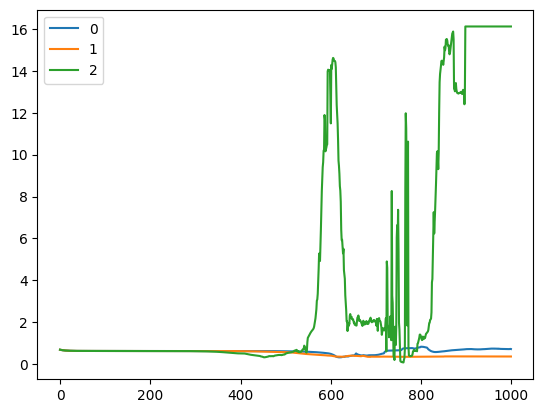

In [68]:
for l in range(len(loss_curves)):
    plt.plot(np.arange(epochs),loss_curves[l],label=str(l))
plt.legend()

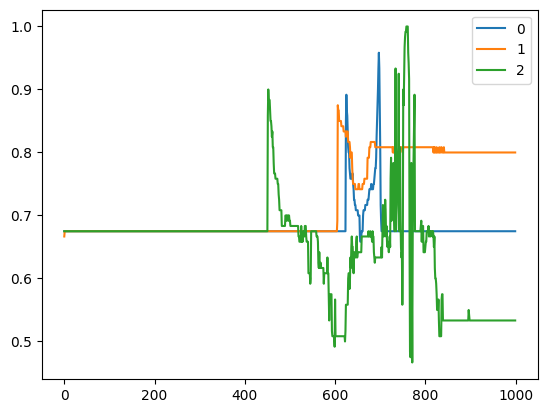

In [69]:
for l in range(len(acc_curves)):
    plt.plot(np.arange(epochs),acc_curves[l],label=str(l))
plt.legend()

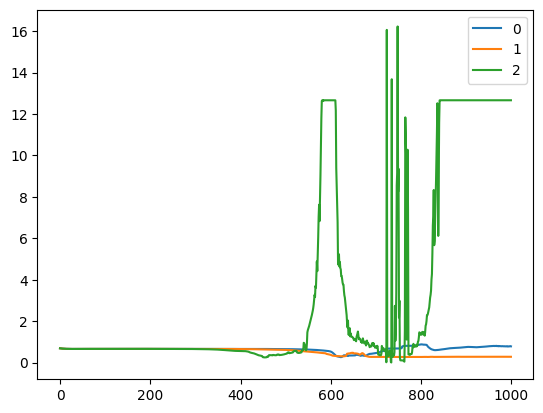

In [70]:
for l in range(len(test_loss_curves)):
    plt.plot(np.arange(epochs),test_loss_curves[l],label=str(l))
plt.legend()

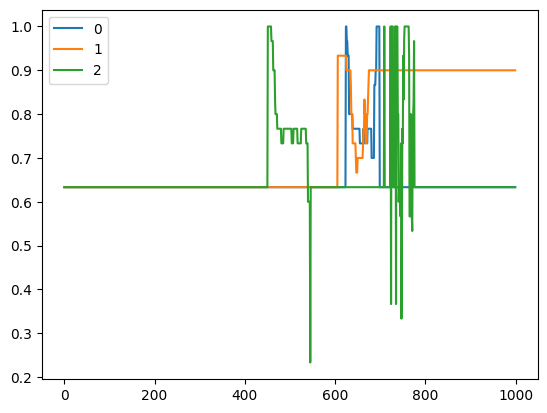

In [71]:
for l in range(len(test_acc_curves)):
    plt.plot(np.arange(epochs),test_acc_curves[l],label=str(l))
plt.legend()

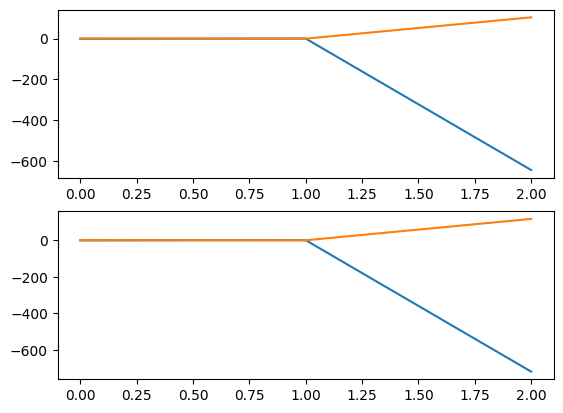

In [72]:
sample_true = np.array([[0],[0],[0],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
sample_false = np.zeros((15,1))
ts_out_neg = []
ts_out_pos = []
fs_out_neg = []
fs_out_pos = []
for i, rnn in enumerate(rnns):
    ts_out, _ = rnn.forward(sample_true,nmodsets[i])
    fs_out, _ = rnn.forward(sample_false,nmodsets[i])
    ts_out_neg.append(ts_out[0])
    ts_out_pos.append(ts_out[1])
    fs_out_neg.append(fs_out[0])
    fs_out_pos.append(fs_out[1])
    
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(ts_out_neg)
ax1.plot(ts_out_pos)
ax2.plot(fs_out_neg)
ax2.plot(fs_out_pos)
plt.show()

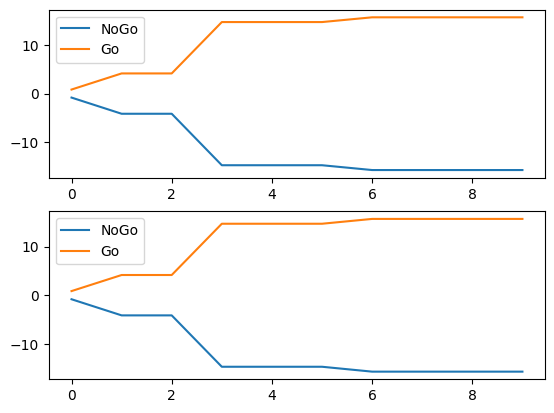

In [73]:
ts_out_neg = []
ts_out_pos = []
fs_out_neg = []
fs_out_pos = []

perm = np.random.permutation(h_size)
for h in range(0,h_size,2):
    nmods = np.zeros((h_size,1))
    for i in range(h):
        nmods[i][0] = 1
    nmods = nmods[perm]
    ts_out, _ = rnns[0].forward(sample_true,nmods)
    fs_out, _ = rnns[0].forward(sample_false,nmods)
    ts_out_neg.append(ts_out[0])
    ts_out_pos.append(ts_out[1])
    fs_out_neg.append(fs_out[0])
    fs_out_pos.append(fs_out[1])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(ts_out_neg,label="NoGo")
ax1.plot(ts_out_pos,label="Go")
ax2.plot(fs_out_neg,label="NoGo")
ax2.plot(fs_out_pos,label="Go")
ax1.legend()
ax2.legend()
plt.show()

In [74]:
for i, rnn in enumerate(rnns):
    test_loss, test_acc = processData(test_input,test_targets,nmodsets[i],rnn,backprop=False)
    print(test_acc)

0.6333333333333333
0.9
0.6333333333333333


In [75]:
perm = np.random.permutation(h_size)
for h in range(0,h_size,2):
    nmods = np.zeros((h_size,1))
    for i in range(h):
        nmods[i][0] = 1
    nmods = nmods[perm]
    test_loss, test_acc = processData(test_input,test_targets,nmods,rnns[0],backprop=False)
    print(test_acc)

0.6333333333333333
0.6333333333333333
0.6333333333333333
0.6333333333333333
0.6333333333333333
0.6333333333333333
0.36666666666666664
0.36666666666666664
0.36666666666666664
0.36666666666666664
